In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
from os.path import join, isdir, isfile
from collections import defaultdict as ddict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

In [ ]:
! tar -xzvf /kaggle/input/cub-200-2011/CUB_200_2011.tgz -C /kaggle/working/

In [3]:
def load_data(data_dir):
    data_path = join(data_dir, 'images')
    
    path_idx_map = dict()
    with open(data_path.replace('images', 'images.txt'), 'r') as f:
        for line in f:
            item = line.strip().split()
            path_idx_map[join(data_path, item[1])] = int(item[0]);
    
    attribute_label_list = ddict(list)
    with open(data_dir+'/attributes/image_attribute_labels.txt', 'r') as f:
        for line in f:
            img_idx, attribute_idx, attribute_label, attribute_certainty = line.strip().split()[:4]
            attribute_label_list[int(img_idx)].append(int(attribute_label))
            
    is_train_test_split = dict()
    with open(data_dir+'/train_test_split.txt', 'r') as f:
        for line in f:
            img_idx, is_train = line.strip().split()
            is_train_test_split[int(img_idx)] = int(is_train)
    
    train_val_data, test_data = [], []
    folder_list = [f for f in listdir(data_path) if isdir(join(data_path, f))]
    folder_list.sort()
    for i, folder in enumerate(folder_list):
        folder_path = join(data_path, folder)
        imgfile_list = [cf for cf in listdir(folder_path) if isfile(join(folder_path, cf)) and cf[0] != '.']
        for cf in imgfile_list:
            img_path = join(folder_path, cf)
            img_id = path_idx_map[img_path]
            metadata = {'id': img_id, 'path': img_path, 'attribute_label': attribute_label_list[img_id], 'class_label': i}
            if is_train_test_split[img_id]:
                train_val_data.append(metadata)
            else:
                test_data.append(metadata)
    
    random.shuffle(train_val_data)
    random.shuffle(test_data)
    val_ratio = 0.1
    split = int(val_ratio*len(train_val_data))
    train_data = train_val_data[split:]
    val_data = train_val_data[:split]
    
    return train_data, val_data, test_data
        
    

In [4]:
class CUBDataset(Dataset):
    def __init__(self, metadata_list, transform=None):
        self.data = metadata_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = img_data['path']
        img = Image.open(img_path).convert('RGB')
        if self.transform == None:
            self.transform = transforms.Compose([
                #transforms.PILToTensor(),
                transforms.Resize((299,299)),
                transforms.ToTensor(),
            ])
        img = self.transform(img)
        class_label = img_data['class_label']
        attributes = torch.tensor(img_data['attribute_label'], dtype=torch.float32)
        return img, attributes, class_label

In [5]:
class MLP(nn.Module):
    def __init__(self, num_concepts, mid_dim, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_concepts, num_classes),
            #nn.ReLU(inplace=True),
            #nn.Linear(1000, 1000),
            #nn.ReLU(inplace=True),
            #nn.Linear(mid_dim, num_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x;

    

In [6]:
def initialize_pretrained_model(num_concepts = 312):
    model = models.resnet18(pretrained=True)
    for params in model.parameters():
        params.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_concepts)
    return model

In [7]:
def train(model, dataloader, optimizer, loss_fn, att_to_y, device, num_epochs=50):
    epoch_loss = {'train':[], 'val': []}
    epoch_acc = {'train': [], 'val': []}
    epoch_recall = {'train': 0.0, 'val': 0.0}
    for e in range(num_epochs):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            con_pos = 0.0
            atr_pos = 0.0
            for img, attribs, label in dataloader[phase]:
                img, attribs, label = img.to(device), attribs.to(device), label.to(device)
                input_data = attribs if att_to_y else img
                grd_truth = label if att_to_y else attribs
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    output = model(input_data)
                    loss = loss_fn(output, grd_truth)
                    #print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if att_to_y == True:
                        pred_dist = nn.Softmax(dim=1)(output)
                        _, pred_label = torch.max(pred_dist, dim=1)
                        acc = torch.sum(pred_label==label.data)
                    else:
                        concept = nn.Sigmoid()(output)
                        concept = (concept > 0.5).type(dtype=torch.int32)
                        con_pos += torch.sum(concept).item()
                        atr_pos += torch.sum(attribs).item()
                        acc = torch.sum(concept == attribs.data)/(attribs.shape[1])
                running_loss += loss.item()
                running_acc += acc.item()
            epoch_loss[phase].append(running_loss/len(dataloader[phase].dataset))
            epoch_acc[phase].append(running_acc/len(dataloader[phase].dataset))
            if att_to_y==False:
                epoch_recall[phase] = con_pos/atr_pos
        
        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Validation loss: {:.4f} | Training acc: {:.4f} | Validation acc: {:.4f} | Training recall: {:.4f} | Validation recall: {:.4f}'.format(e, num_epochs, epoch_loss['train'][-1], epoch_loss['val'][-1], epoch_acc['train'][-1], epoch_acc['val'][-1], epoch_recall['train'], epoch_recall['val']))
    return epoch_loss

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
batch_size = 64
train_data, val_data, test_data = load_data('/kaggle/working/CUB_200_2011')
train_dataset = CUBDataset(train_data, data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
val_dataset = CUBDataset(val_data, data_transforms['val'])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_dataset = CUBDataset(test_data, data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

dataloader = {'train': train_dataloader, 'val': val_dataloader}

tensor([129, 114,  19,  42,   0,  58,  34, 113, 186, 174, 183,   2,  78,  48,
        124, 192, 162, 187,  38,  25,  86,  41,  10, 161, 163, 185,  90, 104,
        180, 182, 132, 158,  54,  97, 114, 156, 104,  74, 114, 185,  65,  23,
        144,  59, 148,  57,  56,  43,  93, 168,  72,  31,   5, 106, 152, 197,
         30,  46,  70,  75,  56, 133, 171,  99])


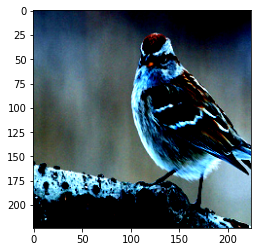

In [10]:
for img, attribute, label in train_dataloader:
    plt.imshow(img[0].permute(1,2,0))
    #attribute = torch.tensor(attribute, dtype=torch.float32)
    print(label)
    break

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
concept_model = initialize_pretrained_model(num_concepts=312).to(device)
classifier_model = MLP(num_concepts=312, mid_dim=500, num_classes=200).to(device)

criterion = nn.CrossEntropyLoss().to(device)
attribs_criterion = []
ac_cri = nn.BCEWithLogitsLoss().to(device)
pos_weight = torch.tensor(5)
for i in range(312):
    attribs_criterion.append(nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight).to(device))

params_to_update = []
for name,param in concept_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)        

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
def attribs_loss_fun(pred, attribs):
    loss = torch.tensor(0, dtype=torch.float32, device=device)
    for i in range(312):
        loss += attribs_criterion[i](pred[:,i], attribs[:,i])
    return loss

In [13]:
concept_optimizer = optim.Adam(params_to_update, lr=0.001)
classfier_optimizer = optim.Adam(classifier_model.parameters(), lr=0.01, weight_decay=0.001)

In [14]:
epoch_loss = train(concept_model, dataloader, concept_optimizer, attribs_loss_fun, att_to_y=False, device=device, num_epochs=13)

Epoch 0/13 : Training loss: 205.3161 | Validation loss: 183.7462 | Training acc: 0.8156 | Validation acc: 0.8403 | Training recall: 2.1854 | Validation recall: 2.0104
Epoch 1/13 : Training loss: 182.8707 | Validation loss: 176.1113 | Training acc: 0.8420 | Validation acc: 0.8501 | Training recall: 2.0001 | Validation recall: 1.9351
Epoch 2/13 : Training loss: 176.6716 | Validation loss: 173.0442 | Training acc: 0.8470 | Validation acc: 0.8524 | Training recall: 1.9743 | Validation recall: 1.9244
Epoch 3/13 : Training loss: 172.8551 | Validation loss: 171.6447 | Training acc: 0.8499 | Validation acc: 0.8542 | Training recall: 1.9609 | Validation recall: 1.9115
Epoch 4/13 : Training loss: 170.4451 | Validation loss: 170.8120 | Training acc: 0.8511 | Validation acc: 0.8557 | Training recall: 1.9587 | Validation recall: 1.8946
Epoch 5/13 : Training loss: 169.1184 | Validation loss: 170.4768 | Training acc: 0.8521 | Validation acc: 0.8554 | Training recall: 1.9570 | Validation recall: 1.900

In [15]:
def plot_loss(train_loss, val_loss, num_epochs):   
    fig = plt.figure(figsize=[15,5])
    plt.plot(range(num_epochs), train_loss, label='train_loss')
    plt.plot(range(num_epochs), val_loss, label='val_score')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

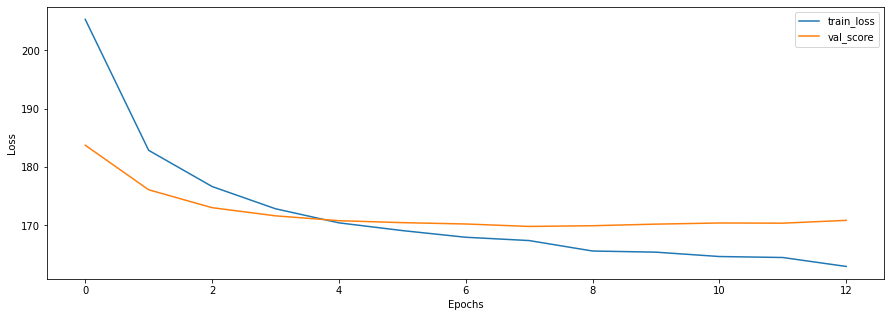

In [16]:
plot_loss(epoch_loss['train'], epoch_loss['val'], 13)

In [17]:
mlp_epoch_loss = train(classifier_model, dataloader, classfier_optimizer, criterion, att_to_y=True, device=device, num_epochs=10)

Epoch 0/10 : Training loss: 0.0588 | Validation loss: 0.0493 | Training acc: 0.2606 | Validation acc: 0.3873 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 1/10 : Training loss: 0.0368 | Validation loss: 0.0444 | Training acc: 0.5707 | Validation acc: 0.4374 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 2/10 : Training loss: 0.0320 | Validation loss: 0.0424 | Training acc: 0.6326 | Validation acc: 0.4441 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 3/10 : Training loss: 0.0295 | Validation loss: 0.0414 | Training acc: 0.6638 | Validation acc: 0.4558 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 4/10 : Training loss: 0.0279 | Validation loss: 0.0409 | Training acc: 0.6793 | Validation acc: 0.4658 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 5/10 : Training loss: 0.0269 | Validation loss: 0.0405 | Training acc: 0.6893 | Validation acc: 0.4574 | Training recall: 0.0000 | Validation recall: 0.0000
Epoch 6/10 : Training 

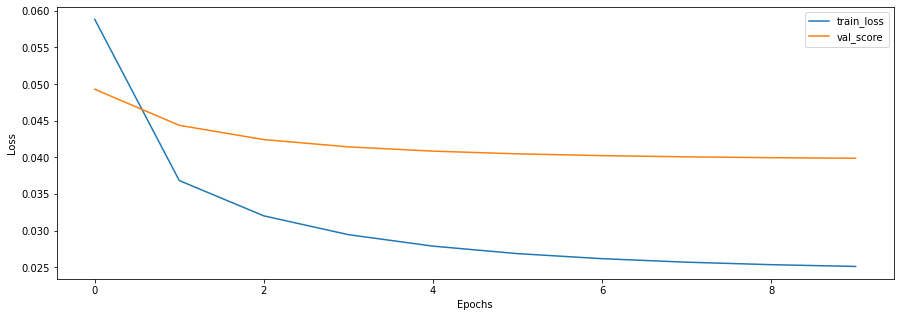

In [18]:
plot_loss(mlp_epoch_loss['train'], mlp_epoch_loss['val'], 10)

In [19]:
def test_model(test_dataloader):
    concept_model.eval()
    classifier_model.eval()
    loss = 0.0
    acc = 0.0
    with torch.no_grad():
        for img, attribs, label in test_dataloader:
            img, attribs, label = img.to(device), attribs.to(device), label.to(device)
            concept = nn.Sigmoid()(concept_model(img))
            pred_dist = nn.Softmax(dim=1)(classifier_model(concept))
            _, pred_label = torch.max(pred_dist, dim=1)
            acc += torch.sum(pred_label == label.data)
        acc = acc/len(test_dataloader.dataset)
    print("Test accuracy: ", acc)
            

In [20]:
test_model(test_dataloader)

Test accuracy:  tensor(0.2078, device='cuda:0')


In [21]:
torch.save(concept_model, 'indep_concept_model.pth')
torch.save(classifier_model, 'indep_classifier_model.pth')

In [22]:
torch.save(concept_model.state_dict(), 'indep_concept_model_state_dict.pth')
torch.save(classifier_model.state_dict(), 'indep_classifier_model_state_dict.pth')
